In [179]:
OPENAI_API_KEY='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'
FIRECRAWL_API_KEY='fc-e36282d62d1c4ee8971ec0649f3862c7'
BASE_URL='https://api.groq.com/openai/v1'
MODEL="meta-llama/llama-4-scout-17b-16e-instruct"

In [180]:
import sys
sys.path.append('..')
print(sys.path)
from tools.fetching_description_from_huggingface import fetching_description_from_huggingface
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor
from pydantic import BaseModel, Field
from langchain.tools import Tool
from firecrawl import FirecrawlApp
from langchain_core.output_parsers import PydanticOutputParser
import pandas as pd
import pprint

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/mnt/g/Ai agents course/LangGraph/venv/lib/python3.12/site-packages', '..', '..', '..', '..']


In [181]:
df_task = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Public task.csv")
df_model = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Model zoo.csv")

In [182]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [183]:
def format_model_list(df):
    model_strings = []
    for i, row in df.iterrows():
        desc = str(row[1]).replace("{", "{{").replace("}", "}}")
        url = str(row[2])
        model_strings.append(f"{i + 1} - {desc} [More info]({url})")
    return "\n".join(model_strings)


# Tools

In [184]:
def web_scraper(url: str) -> str:
    """Get more details about the model using the model url"""
    # scraper = FirecrawlApp(api_key=FIRECRAWL_API_KEY)
    # scrape_status = scraper.scrape_url(
    #     url,
    #     formats=['markdown']
    # )
    # return scrape_status.markdown
    result = fetching_description_from_huggingface(url)
    return result

In [185]:
class WebScraperParameters(BaseModel):
    url: str

In [186]:
res = web_scraper('https://huggingface.co/thanhtlx/image_classification_01')

In [187]:
tools = [
    Tool(
        name="web_scrapper",
        func=web_scraper,
        description="Use to get more detail about the model",
        args_schema=WebScraperParameters
    )
]

# Output Format

In [188]:
class Tasks(BaseModel):
    subtask_one: str = Field(
        ...,
        description="Detailed description of task 1"
    )
    subtask_two: str = Field(
        ...,
        description="Detailed description of task 2"
    )
    subtask_three: str = Field(
        ...,
        description="Detailed description of task 3"
    )
    subtask_four: str = Field(
        ...,
        description="Detailed description of task 4"
    )

In [189]:
class ModelInfo(BaseModel):
    model: str = Field(..., description="Model name and description")
    url: str = Field(..., description="URL to the model")

class ModelSelection(BaseModel):
    models: List[ModelInfo] = Field(..., description="List of available models with name and URL")

In [190]:
class ModelingOutput(BaseModel):
    model_description: str = Field(
        ...,
        description="The detailed description of the model."
    )
    model_input_format: str = Field(
        ...,
        description="Model's detailed input format"
    )
    model_output_format: str = Field(
        ...,
        description="Model's detailed output format"
    )
    model_requirements: str = Field(
        ...,
        description="Requirement libraries need to install to use the model."
    )
    model_sample_code: str = Field(
        ...,
        description="Example code to use the model"
    )

class ModelList(BaseModel):
    models: List[ModelingOutput] = Field(
        ...,
        description="List of suitable model for given task"
    )

# Agent

In [191]:
llm = ChatOpenAI( 
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.7
)

In [192]:
class AgentState(TypedDict):
    task: HumanMessage | None
    data: str | None
    messages: Annotated[List[BaseMessage], add_messages]
    subtasks: Tasks
    models: ModelSelection
    model_description: str
    model_detailed_list: ModelList
    output_classes: str | None
    code: str | None

## Task Formulation Agent

In [193]:
def classify_agent(state: AgentState) -> AgentState:
    structured_llm = llm.with_structured_output(Tasks)
    system_prompt = """
        You are an expert in task formulation. Given a machine learning task, you will
        help divide the task into these subtasks:
        - Subtask1: for identifying task description and classify the problem type.
        - Subtask2: for identifying the problem requirements as described in the "Yêu cầu cụ thể cần đạt được" (or other equivalent) section, including: problem requirements, expected input and expected output.
        - Subtask3: for identifying the input format of the problem, as being described in the "Định dạng dữ liệu đầu vào cho bài toán tổng thể" (or other equivalent) section.
        - Subtask4: for identifying the output format of the problem with the given classes, as being described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" (or other equivalent) section.

        You **MUST** follow these guidelines:
        - Do not mistake the output classes with the one described in the problem requirements. The output classes **MUST** contain the classes described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" section.
        - Describe the subtasks as specific as possible.
        """
    messages = [SystemMessage(content=system_prompt)]
    messages.append(state['task'])
    result = structured_llm.invoke(messages)
    state['subtasks'] = result
    return state

### Testing task formulation agent

In [194]:
task = df_task["Task"][5]

In [195]:
state = {
    "task": HumanMessage(content=task),
    "messages": []
}

In [196]:
state = classify_agent(state)

In [197]:
pprint.pprint(state['subtasks'].subtask_one)
pprint.pprint(state['subtasks'].subtask_two)
pprint.pprint(state['subtasks'].subtask_three)
pprint.pprint(state['subtasks'].subtask_four)


('Identify the task description and classify the problem type. The task is to '
 "build an intelligent system that can analyze each image in Alice's magical "
 'box and decide what it contains. The problem type is image classification '
 'with object detection and emotion recognition.')
("Identify the problem requirements as described in the 'Yêu cầu cụ thể cần "
 "đạt được' section. The system should:\n"
 '  - Detect all visible dogs in an image and identify their breed.\n'
 '  - Return the most frequent breed in the image if dogs are present.\n'
 "  - Look at a cat's facial expression and determine its most likely emotion "
 'if a single cat is present.\n'
 "  - Return 'unsure' if the image is unclear or no visible pet is present.\n"
 '  - Save the result to a file named output.csv with the format: id (image '
 "filename without extension), prediction (most frequent dog breed, cat's "
 "emotion, or 'unsure').")
('Identify the input format of the problem. The images are stored in the 

## Model Selection Agent

In [198]:
model_selection_parser = PydanticOutputParser(pydantic_object=ModelSelection)

In [199]:
def model_selection_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the suitable model for a given task.
                    Given:
                    - A user description about the task
                    - A list of available model (names and links)
                    Your job is to choose ALL suitable models provided in the list for user's specific tasks.
                    Return the answer in the format
                    {structured_output}
                    Here are the list of model:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{input}")
    ]).partial(structured_output=model_selection_parser.get_format_instructions())

    chain = prompt | llm | model_selection_parser

    result = chain.invoke({"input": state['task'], "model_list": format_model_list(df_model)})
    state['models'] = result
    return state

### Testing model selection agent

In [200]:
state = model_selection_agent(state)

/tmp/ipykernel_14401/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_14401/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])


In [201]:
pprint.pprint(state['models'].models)

[ModelInfo(model='Phân loại hình ảnh giống chó', url='https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'),
 ModelInfo(model='Nhận diện cảm xúc mèo', url='https://huggingface.co/semihdervis/cat-emotion-classifier'),
 ModelInfo(model='Phân loại hình ảnh thành100 lớp đối tượng chi tiết (fine-grained)', url='https://huggingface.co/zhaospei/Model_6')]


## Model Selection using Tool Agent

In [262]:
def model_selection_using_tool_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the **Best-fit model** for a given task.
                    Given:
                    - A user task description
                    - A list of available models (names and url)
                    - A tool that fetches model details from a provided URL (it help gathers model description, input/output format, code sample usage)

                    Your job is to:
                    1. Use the **provided tool** to retrieve real details about each candidate model:
                        - ✅ Model description
                        - 📥 Input format
                        - 📤 Output format
                        - 🛠️ Library requirements
                        - 🧪 Code sample (usage code snippet)
                    2. Select the best model for user given task based on the data that the tool gives you.

                    ⚠️ VERY IMPORTANT RULES

                    - ❌ DO NOT assume or invent any part of the model's description, input/output format, requirements or code
                    - ❌ DO NOT generate fake code or use your own knowledge about the model
                    - ✅ ONLY use the **actual output** returned from the tool
                    - ✅ Include tool content in your final answer exactly as returned (especially code)

                    ## 🧠 Output Structure (Final Answer)

                    After retrieving tool results, choose best-fit model for the task (You may need to choose more than one model for some tasks), only choose the model 
                    that strictly relevant to the task and output the model result in the following format:

                    **✅ Model name and link**  
                    `<model name>` — `<link>`

                    **📝 Description (from tool):**  
                    <model description>

                    **📥 Input format (from tool):**  
                    <description of expected input>

                    **📤 Output format (from tool):**  
                    <description of model output>

                    **🛠️ Library Requirements (from tool) **
                    <requirements to use the model>

                    **🧪 Example code (from tool):**  
                    ```python
                    <exact code snippet from tool>

                    Here are the list of models and there corresponding URL:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("ai", "{agent_scratchpad}"),
        ("human", "{input}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    result = executor.invoke({"input": state['task'], "model_list": state['models'].models})
    state['model_description'] = result['output']
    return state
    # return {"output": result["output"]}

### Testing

In [263]:
state = model_selection_using_tool_agent(state)



> Entering new AgentExecutor chain...

Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/zhaospei/Model_3'}`
responded: Given the task description and the list of available models, I will first use the `web_scrapper` function to retrieve details about each candidate model.

I have two models:
- Dự đoán giá trung bình nhà ở các quận Cali — https://huggingface.co/zhaospei/Model_3
- Dự đoán giá trung bình nhà ở các quận Cali — https://huggingface.co/zhaospei/Model_2

Let's start by retrieving details about the first model:




🏠 Mô hình Dự đoán Giá Nhà California (MLP)
📝 Mô tả
Đây là một mô hình multi-layer perceptron (MLP) được huấn luyện trên tập dữ liệu California Housing để dự đoán giá nhà trung bình (MedHouseVal). Mô hình được xây dựng bằng PyTorch, là bản chuyển thể từ mô hình TensorFlow trong Chương 10 của cuốn Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow của Aurelien Geron.
📌 Nhiệm vụ
Dự đoán giá nhà dựa trên các đặc trưng đầu vào dạng bảng (ta

In [264]:
pprint.pprint(state['model_description'])

('Based on the task description and the requirements, I will now proceed to '
 'analyze the models provided.\n'
 '\n'
 "I have retrieved the details for both models. Now, let's compare and select "
 'the best model for the task.\n'
 '\n'
 '**Model 1:**\n'
 '`Dự đoán giá trung bình nhà ở các quận Cali` — '
 '`https://huggingface.co/zhaospei/Model_3`\n'
 '\n'
 '**Description (from tool):**\n'
 'Đây là một mô hình multi-layer perceptron (MLP) được huấn luyện trên tập dữ '
 'liệu California Housing để dự đoán giá nhà trung bình (MedHouseVal). Mô hình '
 'được xây dựng bằng PyTorch, là bản chuyển thể từ mô hình TensorFlow trong '
 'Chương10 của cuốn Hands-On Machine Learning with Scikit-Learn, Keras, and '
 'TensorFlow của Aurelien Geron.\n'
 '\n'
 '**Input format (from tool):**\n'
 'Số chiều: [batch_size,8]\n'
 'Kiểu dữ liệu: torch.FloatTensor\n'
 'Các đặc trưng:\n'
 "'MedInc' – Thu nhập trung vị\n"
 "'HouseAge' – Tuổi trung bình của căn nhà\n"
 "'AveRooms' – Số phòng trung bình\n"
 "'AveB

## Output Parser Agent

In [205]:
parser = PydanticOutputParser(pydantic_object=ModelList)

In [206]:
output_parser_llm = ChatOpenAI(
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0
)

In [207]:
def output_parser_agent(state: AgentState):
    system_prompt = """
                    You are a smart AI tasked with extracting structured technical details about a machine learning model from a reasoning result.
                    You are given a detailed text description about a model (or a list of model).
                    Your goal is to fill the following fields using the data about chosen models based on the text:

                    - `model_description`: A detailed explanation of what the model is and what it does.
                    - `model_input_format`: A detailed description of the model's input format, including dimensions, data types, and expected preprocessing if mentioned.
                    - `model_output_format`: A detailed description of the output format including dimensions, data types, label name and its meaning.
                    - `model_requirements`: A detailed description about the requirements needed to be sastified in order to use the model
                    - `model_sample_code`: A sample code on how to use the model.

                    You MUSTN'T create any data on your own, only using the data provided in the text.

                    Return the data as a JSON object matching the following structure:
                    {formatted_output}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())
    chain = prompt | llm | parser
    # response = chain.invoke({"input": res2['output']})
    # return response
    response = chain.invoke({"input": state['model_description']})
    state['model_detailed_list'] = response
    return state

### Testing

In [265]:
state = output_parser_agent(state)

In [266]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('Đây là một mô hình multi-layer perceptron (MLP) được huấn luyện trên tập dữ '
 'liệu California Housing để dự đoán giá nhà trung bình (MedHouseVal). Mô hình '
 'được xây dựng bằng PyTorch, là bản chuyển thể từ mô hình TensorFlow trong '
 'Chương10 của cuốn Hands-On Machine Learning with Scikit-Learn, Keras, and '
 'TensorFlow của Aurelien Geron.')
('Số chiều: [batch_size,8]\n'
 'Kiểu dữ liệu: torch.FloatTensor\n'
 'Các đặc trưng:\n'
 "'MedInc' – Thu nhập trung vị\n"
 "'HouseAge' – Tuổi trung bình của căn nhà\n"
 "'AveRooms' – Số phòng trung bình\n"
 "'AveBedrms' – Số phòng ngủ trung bình\n"
 "'Population' – Dân số\n"
 "'AveOccup' – Số người trung bình trên mỗi hộ\n"
 "'Latitude' – Vĩ độ\n"
 "'Longitude' – Kinh độ")
('Kiểu: torch.FloatTensor có shape [batch_size,1]\n'
 'Ý nghĩa: Một giá trị thực duy nhất dự đoán giá nhà trung bình cho mỗi mẫu.')
('Cài đặt thư viện cần thiết bằng:\n'
 'pip install torch scikit-learn huggingface_hub')
('```python\n'
 'import torch\n'
 'import t

## Output Labeling Agent

In [210]:
def output_agent(state: AgentState) -> AgentState:
    prompt = r"""
        Your are a specialist in machine learning. Your task is to identify the absolute classes of the given problem description, following with an output description.
        ### Input:
        - Problem description: {problem_description}
        - Output description: {output_description}

        You must return an array, strictly following these guidelines:
        - Understand the context from the given problem description.
        - Extract the class names from the output description. You **must not** invent new labels or translate the class names. Use them exactly as given in the output description.
        - Create an array containing the classes.

        You must return only the array containing those classes, without any formatting.
    """

    prompt = prompt.format(
        problem_description = state['task'],
        output_description = state["subtasks"].subtask_four
    )
    response = llm.invoke(prompt)
    return {**state, "output_classes": response.content}

### testing

In [211]:
state = output_agent(state)
print(state['output_classes'])

unsure
happy
angry
curious
relaxed 
unsure 
bulldog 
beagle 
poodle 
pug 
chihuahua 
shih tzu 
corgi 
cat 
dog


## Coding Agent

In [221]:
def coding_agent(state: AgentState) -> AgentState:
    base_prompt = r"""
    You are a specialist in Machine Learning. Your task is to generate a *fully functional with all necessary imports and dependencies* codebase in *Python* that can be executed flawlessly.

    You will be provided with:
    - A problem description
    - An input specification
    - An output specification
    - A description of one or many models that you needed to use
    - A list of model needed to use to solve the problem

    ### Input:
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML Model list and there detailed description: {model_list}
    - Output classes: {output_classes}

    ### Guidelines

    You *must* strictly follow the following guidelines:
    - The preprocessing step should be suitable for the data type.
    - The postprocessing step should notices the differences between the data returned by the model and the output requirements. You must extract and use the exact class labels as defined in the output specification.
    - Do *not invent new labels or translate* the class names. Use them exactly as given.
    - You *must* make sure that your codebase can be executed flawlessly that would not encounter any errors or exceptions.
    - **Important**: The code will run automatically without requiring or involving any human input during execution."

    Your implementation *must strictly follow* the structure below:
    1. *Imports*: All required libraries.
    2. *Preprocessing*: Handle and transform the input as defined.
    3. *Inference logic*: Use the described model for prediction. You *must* use tqdm or similar logging library to track progress.
    4. *Postprocessing*: Format or transform the raw output into the final result as described.

    You must *not* include any explanations, markdown, or logging outside what is required by the problem.

    Return *only* the complete Python codebase, and you **MUST NOT** include a main function in any way. Wrap it with:
    \`\`\`python
    # code here
    \`\`\`
    """

    prompt = base_prompt.format(
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'].models,
        output_classes=state["output_classes"],
    )
    response = llm.invoke(prompt)
    state['code'] = response.content
    # return {**state, "code": response.content}
    return state

### testing

In [226]:
state = coding_agent(state)
print(state['code'])

```python
import os
import csv
from PIL import Image
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm import tqdm
import numpy as np

# Define constants
IMAGE_FOLDER = 'images'
OUTPUT_FILE = 'output.csv'

# Load pre-trained model and processor
model_name = "thanhtlx/image_classification_01"
model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

# Function to check if a number is prime
def is_prime(n):
    if n <= 1:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    max_divisor = int(np.sqrt(n)) + 1
    for d in range(3, max_divisor, 2):
        if n % d == 0:
            return False
    return True

# Preprocess and make predictions
with open(OUTPUT_FILE, 'w', newline='') as csvfile:
    fieldnames = ['file_name', 'prediction']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for file_na

# Graph

In [242]:
def init_agent(state: AgentState):
    state = {
        "messages": [],
        "task": state["task"],
        "data": None,
        "subtasks": None,
        "models": None,
        "model_detailed_list": None,
        "output_classes": None,
        "code": None
    }
    return state

In [243]:
graph = StateGraph(AgentState)
graph.add_node("init_node", init_agent)
graph.add_node("formulation_node", classify_agent)
graph.add_node("model_selection_node", model_selection_agent)
graph.add_node("model_selection_using_tool_node", model_selection_using_tool_agent)
graph.add_node("model_output_parser_node", output_parser_agent)
graph.add_node("labeling_node", output_agent)
graph.add_node("coding_node", coding_agent)

graph.add_edge(START, "init_node")
graph.add_edge("init_node", "formulation_node")
graph.add_edge("formulation_node", "model_selection_node")
graph.add_edge("model_selection_node", "model_selection_using_tool_node")
graph.add_edge("model_selection_using_tool_node", "model_output_parser_node")
graph.add_edge("model_output_parser_node", "labeling_node")
graph.add_edge("labeling_node", "coding_node")
graph.add_edge("coding_node", END)

app = graph.compile()

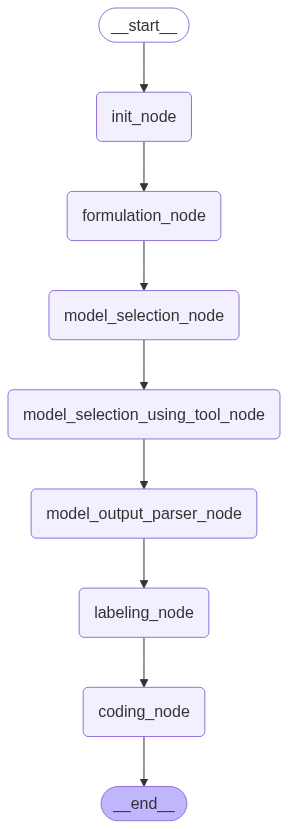

In [244]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

### testing

In [249]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [267]:
task_no = 5
task = df_task["Task"][task_no]

In [268]:
state = app.invoke({"task": task})

/tmp/ipykernel_14401/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_14401/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])




> Entering new AgentExecutor chain...

Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/zhaospei/Model_6'}`
responded: To solve Alice's problem, we need a system that can analyze images and categorize them based on their content: dogs (with breed identification), a single cat (with emotion detection), or unsure (if the image is unclear). Given the models provided:

1. **Phân loại hình ảnh thành100 lớp đối tượng chi tiết (fine-grained)** — https://huggingface.co/zhaospei/Model_6
2. **Phân loại hình ảnh giống chó** — https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit
3. **Nhận diện cảm xúc mèo** — https://huggingface.co/semihdervis/cat-emotion-classifier

Let's gather detailed information about each model to determine which ones are suitable for Alice's task.




🖼️ Mô hình Phân loại Ảnh - ViT Fine-tuned trên CIFAR-100
📝 Mô tả
Đây là mô hình Vision Transformer (ViT) được fine-tuned từ mô hình gốc google/vit-base-patch16-224-in21k trên 

## Model Selected

In [269]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
'Fine-tuned ViT model to classify dog images into 120 breeds.'
'Dog images, RGB, 224x224.'
'Predicted dog breed.'
'transformers, PIL, requests'
('from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 'url = "https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg"\n'
 'image = PIL.Image.open(requests.get(url, stream=True).raw)\n'
 'image_processor = '
 'AutoImageProcessor.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'model = '
 'AutoModelForImageClassification.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'inputs = image_processor(images=image, return_tensors="pt")\n'
 'outputs = model(**inputs)\n'
 'logits = outputs.logits\n'
 'predicted_class_idx = logits.argmax(-1).item()\n'
 'print("Predicted class:", model.config.id2label[predicted_class_idx])')
Model 1:
'Fine-tuned ViT model for cat emotion classification.'
'C

## Code Generation

In [270]:
print(state['code'])

```python
import os
import csv
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm

# Define the models and their corresponding labels
models = [
    {"model_name": "dog_breed_classifier", "model_path": "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit", "labels": ["dalmatian", "pug", "poodle", "bulldog", "unsure"]},
    {"model_name": "cat_emotion_classifier", "model_path": "semihdervis/cat-emotion-classifier", "labels": ["happy", "angry", "curious", "relaxed", "unsure"]},
    {"model_name": "image_classifier", "model_path": "zhaospei/Model_6", "labels": list(range(100))}
]

# Load the models and their processors
model_instances = []
for model in models:
    processor = AutoImageProcessor.from_pretrained(model["model_path"])
    model_instance = AutoModelForImageClassification.from_pretrained(model["model_path"])
    model_instances.append({"processor": processor, "model": model_instance,